# YSDA – Machine Learning pt. 2
## Seminar on Graph Neural Networks
### 22.04.2022
### Ilia Igashov

[igashov.github.io](https://igashov.github.io/)

ilia.igashov@gmail.com

# Contents

- Prerequisites
- Part 0: PyTorch Geometric and NetworkX basics
- Part 1: Node embeddings
    - Graph notations
    - Node2vec
    - Nodes clustering with node2vec
- Part 2: Graph Neural Networks
    - Message Passing
    - Graph Convolutional Network (GCN)
    - Graph Attention Network (GAT)
    - Graph Classification on PROTEINS dataset
    - Node Classification on CORA dataset


# Prerequisites

Turn on GPUs

In [1]:
import torch
import os

os.environ['TORCH_VERSION'] = torch.__version__
!echo $TORCH_VERSION

1.11.0+cu113


In [2]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH_VERSION}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH_VERSION}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-${TORCH_VERSION}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-${TORCH_VERSION}.html
!pip install torch-geometric -f https://data.pyg.org/whl/torch-${TORCH_VERSION}.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 4.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 3.5 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 2.5 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 750 kB 4.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking i

# Part 0. PyTorch Geometric and NetworkX basics

We will use [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) (PyG) framework as the main tool for working with graphs. It provides a convenient functionality for operating on:
- [graph structures](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html)
- [graph-learning models](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html)
- [common graph datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html)

Besides, [NetworkX](https://networkx.org/) (NX) library is useful for graph visualization.

Let's create a simple graph with four nodes and five edges, where each node $v_i$ will have an associated feature value, its one-hot encoded index $i$:

<img align="middle" src="https://www.researchgate.net/profile/Panayiota-Poirazi/publication/293945308/figure/fig1/AS:669375778529289@1536603030400/A-simple-graph-consisting-of-4-nodes-and-4-edges-The-degree-of-each-node-is.ppm" width="200"/>

In [3]:
import torch
import networkx as nx

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

In [4]:
# node features – one-hot indices:
x = torch.tensor(
    [
        [1, 0, 0, 0, 0, 0], 
        [0, 1, 0, 0, 0, 0], 
        [0, 0, 1, 0, 0, 0], 
        [0, 0, 0, 1, 0, 0],
    ], 
    dtype=torch.long
)

# edges of the graph:
edge_index = torch.tensor(
    [
        [0, 0, 0, 1, 1, 2, 3, 3],
        [1, 2, 3, 0, 3, 0, 0, 1],
    ], 
    dtype=torch.long
)

# PyG graph:
pg_graph = Data(x=x, edge_index=edge_index)

Let's look at the created PyG graph object:

In [5]:
pg_graph

Data(x=[4, 6], edge_index=[2, 8])

Useful graph attributes:

In [6]:
print('Number of nodes in the graph:', pg_graph.num_nodes)
print('Number of edges in the graph:', pg_graph.num_edges)
print('Number of node features:', pg_graph.num_node_features)

Number of nodes in the graph: 4
Number of edges in the graph: 8
Number of node features: 6


Note that `edge_index`, i.e. the tensor defining the source and target nodes of all edges, **is not a list of index tuples**. If you want to write your indices this way, you should transpose and call `contiguous` on it before passing them to the data constructor:

In [7]:
edge_index = torch.tensor(
    [
        [0, 1],
        [0, 2],
        [0, 3],
        [1, 0],
        [1, 3], 
        [2, 0],
        [3, 0],
        [3, 1],
    ], 
    dtype=torch.long
)

edge_index.t().contiguous()

tensor([[0, 0, 0, 1, 1, 2, 3, 3],
        [1, 2, 3, 0, 3, 0, 0, 1]])

Let's transform PyG graph to the NX format and draw the resulting graph:

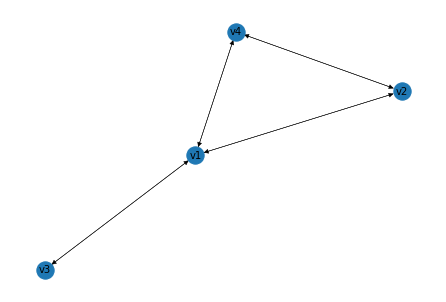

In [8]:
# transform:
nx_graph = to_networkx(pg_graph)

# draw:
nx.draw(
    nx_graph, 
    font_size=10,
    width=0.5, 
    with_labels=True,
    labels={i: f'v{i+1}' for i in range(pg_graph.num_nodes)},
)

Now let's create the second simple graph with two nodes and one edge:

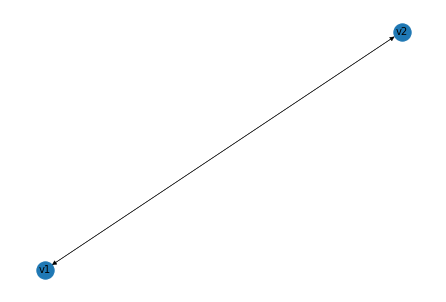

In [9]:
second_pg_graph = Data(
    x=torch.tensor([
        [0, 0, 0, 0, 1, 0], 
        [0, 0, 0, 0, 0, 1],
    ], dtype=torch.long),
    edge_index=torch.tensor([[0, 1], [1, 0]], dtype=torch.long),
)

second_nx_graph = to_networkx(second_pg_graph)

nx.draw(
    second_nx_graph, 
    font_size=10,
    width=0.5, 
    with_labels=True,
    labels={i: f'v{i+1}' for i in range(second_pg_graph.num_nodes)},
)

Let's put both graphs into DataLoader with `batch_size=2`:

In [10]:
loader = DataLoader([pg_graph, second_pg_graph], batch_size=2)

Let's check how many batches the loader is going to generate:

In [11]:
len(loader)

1

Let's see what the loader yields:

In [12]:
for batch in loader:
    print(batch)

DataBatch(x=[6, 6], edge_index=[2, 10], batch=[6], ptr=[3])


The batch object is very similar to the `Data` object, but it has additonal attributes `batch` and `ptr` that what nodes belong to what graphs in the batch:

In [13]:
batch.batch

tensor([0, 0, 0, 0, 1, 1])

In [14]:
batch.ptr

tensor([0, 4, 6])

That means that nodes with indices $0\leq{i}<4$ belong to the first graph in the batch, and nodes with indices $4\leq{i}<6$ belong to the second graph in a batch. For checking that, let's take a look at the attribute `x` of the batch:

In [15]:
batch.x

tensor([[1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]])

So the batch of size $B$ can be thought as a new big graph that contains $B$ disjoint components corresponding to the graphs included in this batch:

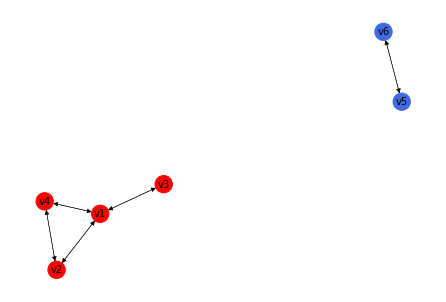

In [16]:
nx_batch = to_networkx(batch)

colors = ['red', 'royalblue']
node_colors = [
    colors[i]
    for i in batch.batch
]

nx.draw(
    nx_batch, 
    font_size=10,
    width=0.5, 
    with_labels=True,
    labels={i: f'v{batch.x[i].argmax()+1}' for i in range(batch.num_nodes)},
    node_color=node_colors,
)

# Part 1. Node embeddings

In this part, we will look at one of the most popular node embedding techniques `node2vec` and embed characters of the novel "Les Misérables" with it.

## Graph notations

Let's consider an *undirected graph* $G=(V, E)$, where $V$ is the set of nodes and $E$ is the set of edges.
For a graph node $u\in V$, we define its neighborhood as 

$$
N(u)=\{v\in{V}\ |\ (u,v)\in E\}. \tag{1}
$$

The adjacency matrix $\boldsymbol{A}$ of graph $G$ is a square $|V|\times|V|$ symmetric matrix where each entry relates to an edge between the corresponding nodes. In case of the *weigted* graph, when each edge $(v_i,v_j)\in E$ has weight $w_{ij}\in\mathbb{R}$, the corresponding entry of the adjacency matrix $a_{ij}$ equals to this weight:

$$
\forall {i,j}\in\{1,\dots,|V|\}\ \ \ \ a_{ij}=
\begin{cases}
w_{ij},\ &\text{if}\ (v_i,v_j)\in{E},\\
0,\ &\text{if}\ (v_i,v_j)\notin{E}.
\end{cases} \tag{2}
$$


In case of the *unweighted* graph, the adjacency matrix is binary:

$$
\forall {i,j}\in\{1,\dots,|V|\}\ \ \ \ a_{ij}=
\begin{cases}
1,\ &\text{if}\ (v_i,v_j)\in{E},\\
0,\ &\text{if}\ (v_i,v_j)\notin{E}.
\end{cases}\tag{3}
$$

## Node2vec

* [original paper](https://arxiv.org/abs/1607.00653)
* [original code](https://github.com/aditya-grover/node2vec)

The node2vec framework learns low-dimensional representations for nodes in a graph by optimizing a neighborhood preserving objective. The objective is flexible, and the algorithm accomodates for various definitions of network neighborhoods by simulating biased random walks. Specifically, it provides a way of balancing the exploration-exploitation tradeoff that in turn leads to representations obeying a spectrum of equivalences from homophily to structural equivalence.

For a graph $G=(E,V)$ `node2vec` computes $d$-dimensional embedding vectors by maximizing the following objective:

$$
\mathcal{L}=\sum_{u\in{V}}\left[
    -\log{\sum_{v\in{V}}e^{f(u)f(v)}}+\sum_{n_i\in{N_S(u)}}f(n_i)f(u)
\right],\tag{4}
$$

where $f(v)$ is a feature vector of node $v$, and $N_S(u)\subset{V}$ is network neighborhood of node $u$ generated through a neighborhood sampling strategy $S$.


Sampling strategy $S$ is a random walk that on each step $i$ randomly chooses the next node according to the following rule,

$$
P(c_i=x|c_{i-1}=v,c_{i-2}=t)=
\begin{cases}
    \frac{\pi(x,v,t)}{Z}\ &\text{if}\ (v,x)\in{E}\\
    0\ &\text{otherwise}
\end{cases}\tag{5}
$$

where $\pi(x,v,t)$ is the unnormalized transition probability and $Z$ is the normalization constant.

The transition probability between $v$ and $x$ depends on the edge weight (if exists) $w_{vx}$ and bias $\alpha$ parametrized by two values $p$ and $q$:

$$
\pi(x,v,u)=\alpha_{pq}(t,x)w_{vx},\ \ \ \
\alpha_{pq}=
\begin{cases}
    \frac{1}{p}\ &\text{if}\ d_{tx}=0\\
    1\ &\text{if}\ d_{tx}=1\\
    \frac{1}{q}\ &\text{if}\ d_{tx}=2\\
\end{cases},\tag{6}
$$

where $d_{tx}$ is the length of the shortest path in a graph between nodes $x$ and $t$.

<div>
  <img align="middle" src="https://d3i71xaburhd42.cloudfront.net/36ee2c8bd605afd48035d15fdc6b8c8842363376/2-Figure1-1.png" width="600"/>
  <img align="middle" src="https://www.machinelearningmastery.ru/img/0-260046-729810.png" width="400"/>
</div>

## Les Misérables

Les Misérables characters network, encoding interactions between characters of [Victor Hugo’s novel](https://en.wikipedia.org/wiki/Les_Mis%C3%A9rables), was first created by Donald Knuth as part of the [Stanford Graph Base](https://people.sc.fsu.edu/~jburkardt/datasets/sgb/sgb.html). It contains 77 nodes corresponding to characters of the novel, and 254 edges connecting two characters whenever they appear in the same chapter.

In [ ]:
!mkdir -p data/lesmis
!wget https://visdatasets.github.io/datasets/les_miserables_nodes.csv -O data/lesmis/les_miserables_nodes.csv
!wget https://visdatasets.github.io/datasets/les_miserables_links.csv -O data/lesmis/les_miserables_links.csv

--2022-04-22 15:43:42--  https://visdatasets.github.io/datasets/les_miserables_nodes.csv
Resolving visdatasets.github.io (visdatasets.github.io)... 185.199.109.153, 185.199.108.153, 185.199.110.153, ...
Connecting to visdatasets.github.io (visdatasets.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1769 (1.7K) [text/csv]
Saving to: ‘data/lesmis/les_miserables_nodes.csv’

data/lesmis/les_mis 100%[===================>]   1.73K  --.-KB/s    in 0s      

2022-04-22 15:43:42 (22.7 MB/s) - ‘data/lesmis/les_miserables_nodes.csv’ saved [1769/1769]

--2022-04-22 15:43:42--  https://visdatasets.github.io/datasets/les_miserables_links.csv
Resolving visdatasets.github.io (visdatasets.github.io)... 185.199.109.153, 185.199.108.153, 185.199.110.153, ...
Connecting to visdatasets.github.io (visdatasets.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5323 (5.2K) [text/csv]
Saving to: ‘data/lesmis/

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch

from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

In [ ]:
links = pd.read_csv('data/lesmis/les_miserables_links.csv')
nodes = pd.read_csv('data/lesmis/les_miserables_nodes.csv')

In [ ]:
nodes.head()

,id,name,group
0,Myriel,Myriel,G1
1,Napoleon,Napoleon,G1
2,Mlle.Baptistine,Mlle.Baptistine,G1
3,Mme.Magloire,Mme.Magloire,G1
4,CountessdeLo,CountessdeLo,G1


In [ ]:
links.head()

,source_id,target_id,value
0,Napoleon,Myriel,1
1,Mlle.Baptistine,Myriel,8
2,Mme.Magloire,Myriel,10
3,Mme.Magloire,Mlle.Baptistine,6
4,CountessdeLo,Myriel,1


We will use [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) (PyG) framework as the main tool for working with graphs. It provides a convenient functionality for operating on:
- [graph structures](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html)
- [graph-learning models](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html)
- [common graph datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html)

Besides, [NetworkX](https://networkx.org/) (NX) library is useful for graph visualization.

Let's create PyG and NX graphs based two tables representing relationships between Les Misérables characters:

In [ ]:
name2id = dict(zip(nodes.name.values, nodes.index))
id2name = dict(zip(nodes.index, nodes.name.values))
id2group = nodes.group.tolist()

# construct PyTorch Geometric graph
x = torch.tensor(nodes.index, dtype=torch.long)
edge_index = torch.tensor(
    [links.source_id.map(name2id), links.target_id.map(name2id)], 
    dtype=torch.long
)
pg_graph = Data(x=x, edge_index=edge_index)

# construct NetworkX graph
nx_graph = to_networkx(pg_graph, to_undirected='lower')

For visualization, we will use NetworkX function `draw`. The function below requires colors for each node.

In [ ]:
COLORS = [
    '#C3EFFC',
    '#FCC4C3',
    '#FCF9C3',
    '#E1FCC3',
    '#C1EFBF',
    '#BFC9EF',
    '#CCBFEF',
    '#EBBFEF',
    '#CCB4C4',
    '#EEEEEE',
    '#FFFFFF',
]

def draw_colored_graph(nx_graph, colors, labels, ax=None):
    if ax is None:
        plt.figure(figsize=(20, 12))
    nx.draw(
        nx_graph, 
        node_color=colors,  
        font_size=10, 
        width=0.2, 
        with_labels=True,
        labels=labels,
        ax=ax
    )

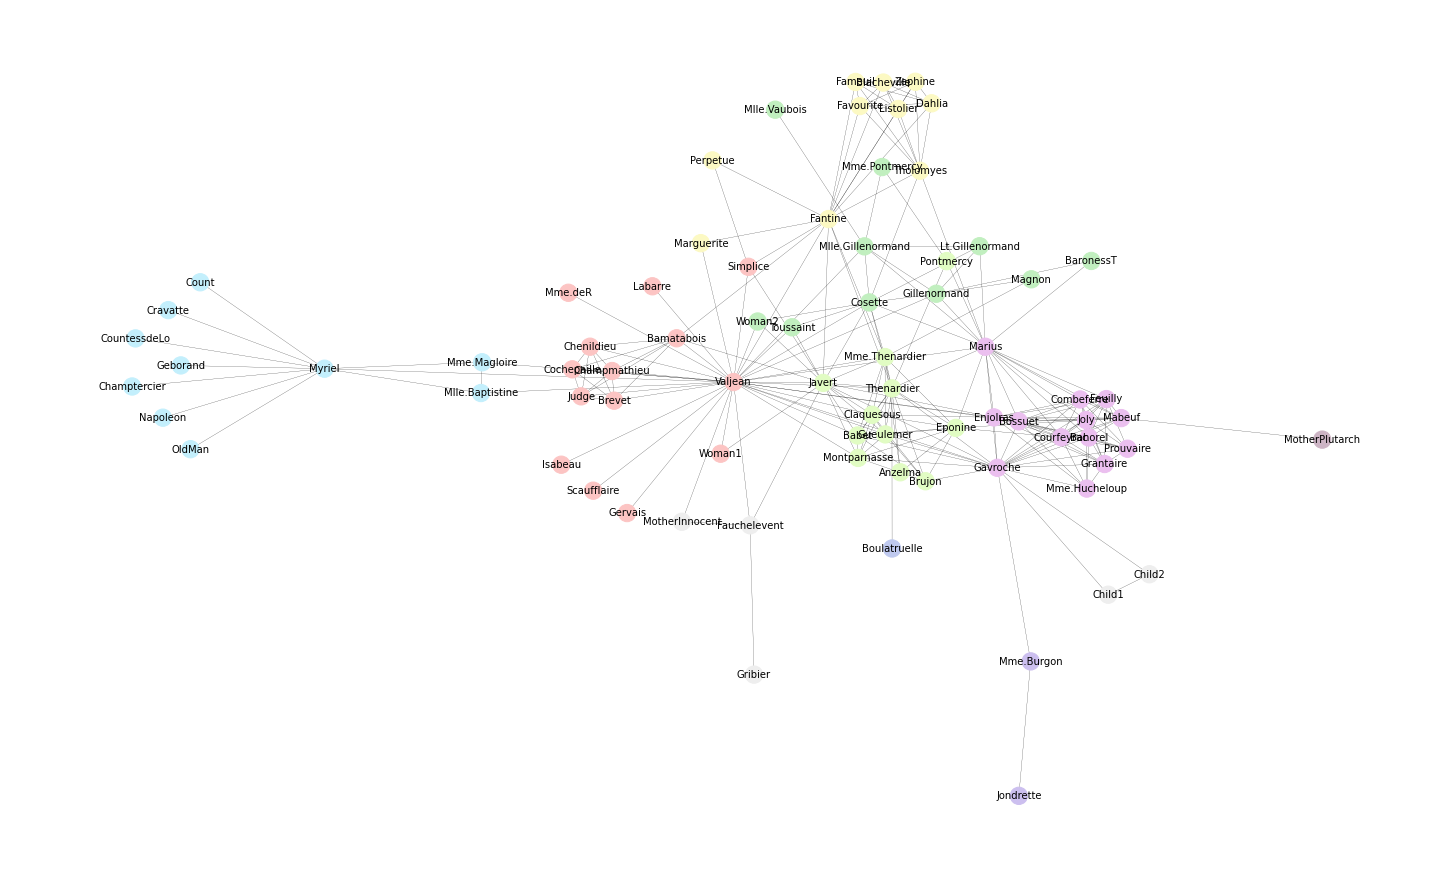

In [ ]:
colors = [
    COLORS[int(group.replace('G', '')) - 1]
    for group in id2group
]

draw_colored_graph(nx_graph, colors, labels=id2name)

## Task 1.1 – Training node2vec

Let's use [node2vec](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/node2vec.html) model implemented in PyTorch Geometric.

In [ ]:
from tqdm import tqdm
from torch.optim import Adam
from torch_geometric.nn.models import Node2Vec

In [ ]:
# Node2Vec parameters
embedding_dim = 8
walk_length = 2
context_size = 2
p = 1
q = 1

# Training parameters
batch_size = 32
learning_rate = 0.01

# Create node2vec model
# YOUR CODE HERE:
model = Node2Vec(
    edge_index=edge_index,
    embedding_dim=embedding_dim,
    walk_length=walk_length, 
    context_size=context_size
)

# Loader and optimizer
loader = model.loader(batch_size=batch_size, shuffle=True)
optimizer = Adam(model.parameters(), lr=learning_rate)

100%|██████████| 500/500 [00:01<00:00, 289.69it/s]


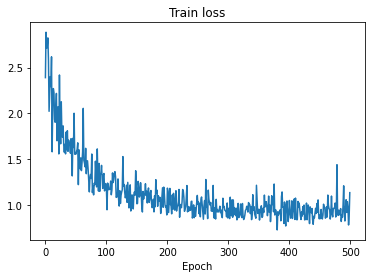

In [ ]:
train_loss = []

for epoch in tqdm(range(500)):
    epoch_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()

        # Compute loss from equation (4)
        # YOUR CODE HERE:
        # Hint: check the interface of the `model` object
        loss = model.loss(pos_rw=pos_rw, neg_rw=neg_rw)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()    
    train_loss.append(epoch_loss / len(loader))
    

plt.plot(train_loss)
plt.title('Train loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
embeddings = model(pg_graph.x)
embeddings.shape

torch.Size([77, 8])

## Task 1.2 – Kmeans clustering

Having node2vec embeddings obtained, let's cluster all characters based on these embeddings and compare the result with the ground-truth clusters `G1`, `G2`, ... (provided in the table `nodes`).

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score

In [ ]:
true_clusters = nodes.group.apply(lambda g: int(g.replace('G', ''))).values

# Cluster node2vec embeddings into 10 clusters
# YOUR CODE HERE:
kmeans = KMeans(n_clusters=11)
pred_clusters = kmeans.fit_predict(embeddings.detach().cpu().numpy())


homogeneity = homogeneity_score(true_clusters, pred_clusters)
print('Homogeneity:', homogeneity)
if homogeneity >= 0.65: 
    print('Good job!')
else:
    print('Try better!')

Homogeneity: 0.7866527196368046
Good job!


In [ ]:
nodes.group.value_counts()

G2     14
G8     13
G4     11
G1     10
G3     10
G5     10
G0      3
G7      2
G10     2
G6      1
G9      1
Name: group, dtype: int64

Let's look at the graph with new clusters:

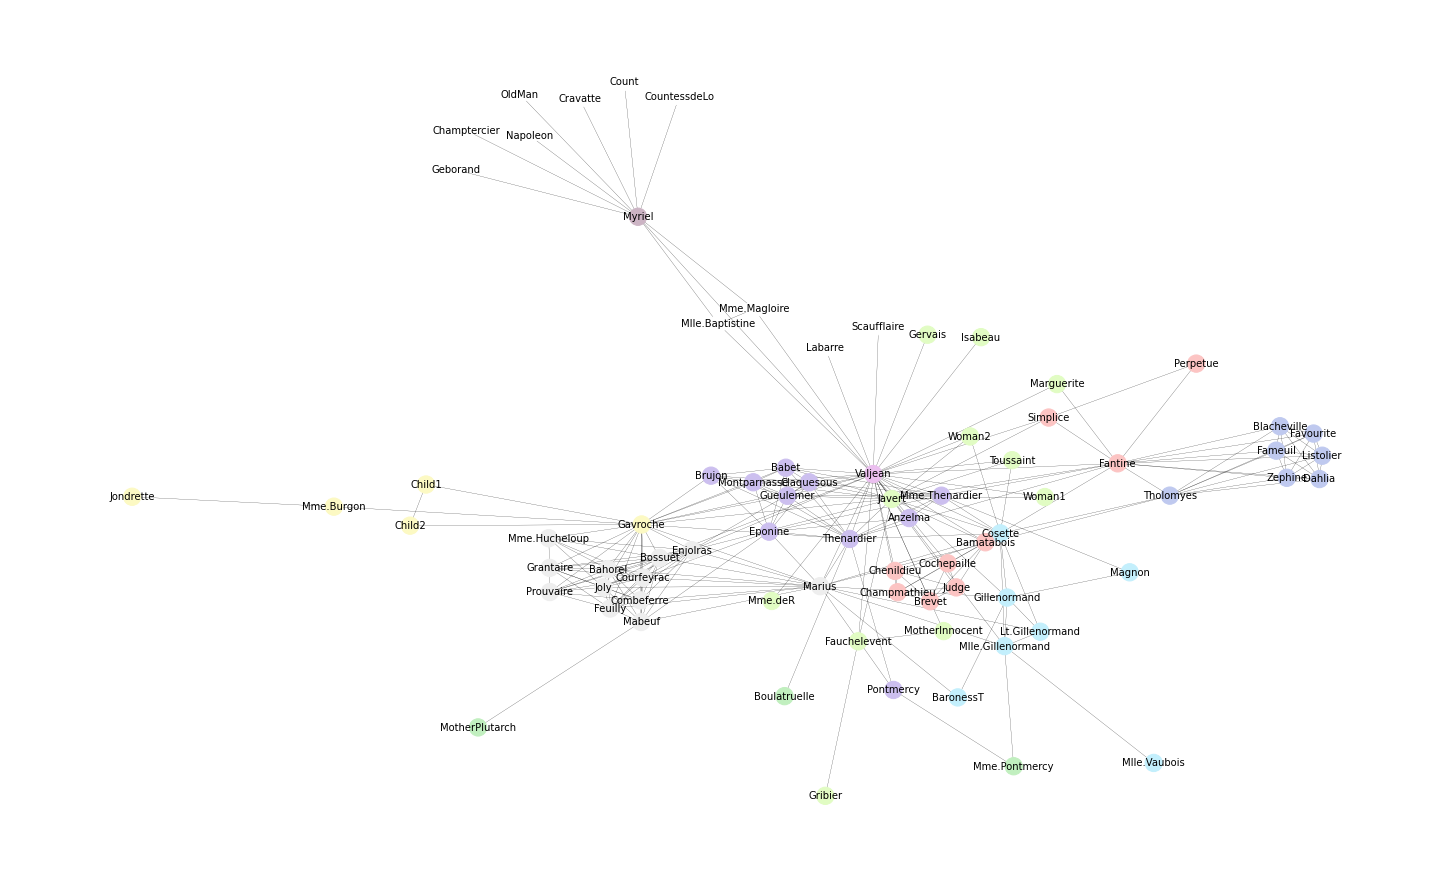

In [ ]:
colors = [
    COLORS[cluster]
    for cluster in pred_clusters
]

draw_colored_graph(nx_graph, colors, labels=id2name)

## Task 1.3 – Visualization with TSNE

Now let's reduce the dimensionality of node2vec embeddings with TSNE and looks at clusters in 2 dimensions:

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# Reduce dimension of embeddings to 2 with TSNE
# YOUR CODE HERE:
tsne = TSNE(n_components=2)
reduced_embeddings = tsne.fit_transform(embeddings.detach().cpu().numpy())

y = np.array(id2group)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


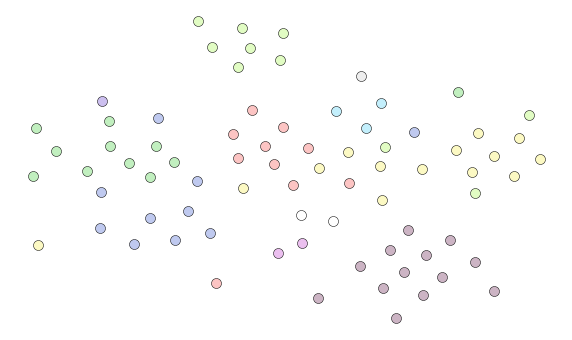

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(11):
    plt.scatter(
        reduced_embeddings[y == f'G{i}', 0], 
        reduced_embeddings[y == f'G{i}', 1], 
        s=100, 
        color=COLORS[i], 
        linewidths=0.5, 
        edgecolors='black'
    )
plt.axis('off')
plt.show()

# Part 2. Graph Neural Networks

## Message Passing

Graph Neural Networks (GNNs) rely on a more generic framework referred to as "Message Passing" that proceeds as follows.

Assume that each node $v_i$ of the input graph $G$ has an associated vector of features $\boldsymbol{z}_i^{0}$ of size $d^0$. Consider $K$ message-passing layers. 

For $k \in \{1,\ldots,K\}$:

* For all nodes $v_i$ and for all its neighbours, we build a message $\color{red}{\boldsymbol{m}_{ij}^{k}}$ with some differentiable function $\phi$:

$$
\color{red}{\boldsymbol{m}_{ij}^{k} \leftarrow \phi(z_i^{k-1},z_j^{k-1})},\tag{7}
$$


* We aggregate the messages in $\color{green}{\boldsymbol{h}_i^{k}}$, a vector of size $d^{k-1}$, using some differentiable and permutation invariant function AGGR:

$$
\color{green}{\boldsymbol{h}_i^{k} \leftarrow \text{AGGR}(\color{red}{\boldsymbol{m}_{ij}^{k}}, \forall v_j \in N(v_i) \cup \{v_i\})},\tag{8}
$$

* We build a new embedding $\boldsymbol{z}^{k}_i$ for each node $v_i$ with $\boldsymbol{W}^{k}$ a matrix of size $d^{k}\times d^{k-1}$:

$$
\boldsymbol{z}^{k}_i \leftarrow \sigma(\boldsymbol{W}^{k} . \color{green}{\boldsymbol{h}_i^{k}}).\tag{9}
$$
    

Finally, we set the embedding of node $i$ as $\boldsymbol{z}_i=\boldsymbol{z}^{K}_i$.

<div>
<img src="https://miro.medium.com/max/1400/1*fPzRm3Flq3dQErn7LEG_Ig.png" width="900"/>
</div>

Note that the user has to choose:

* the number of layers $K$,
* The $\phi$ function,
* the AGGR function, which is an aggregation function (e.g: max, sum, mean),
* the dimensions $d^{k}$ for $k \geq 1$
* $\sigma$, which is a non-linear function (e.g ReLU).

## Graph Convolutional Network

* [original paper](https://arxiv.org/abs/1609.02907)
* [original code](https://github.com/tkipf/gcn)

The Graph Convolutional Network (GCN) is a graph neural network that implements the Message Passing framework such that:

$$
\boldsymbol{z}'_i = 
\color{green}{\sum_{v_j\in{N}(v_i)\cup\{v_i\}}}
\color{red}{
\frac{1}{\sqrt{\text{deg}(v_i)}\sqrt{\text{deg}(v_j)}} 
}
\boldsymbol{\Theta}\boldsymbol{z}_j
,\tag{10}
$$

where $\boldsymbol{\Theta}$ is a weight matrix, and $\text{deg}(v)$ is a degree of the node $v$:

$$
\text{deg}(v) = \sum_{u\in{V}}\mathbb{I}\{(u,v)\in{E}\}.\tag{11}
$$

**Note:** for simplicity, we dropped indices $k$ corresponding to the number of layer. Instead, we use prime `'` as an indication of the updated embeddings. We assume that each node $v_i$ has an embedding vector $\boldsymbol{z}_i\in\mathbb{R}^d$ before applying the convolution layer, and gets an updated embedding vector $\boldsymbol{z}'_i\in\mathbb{R}^{d'}$ after applying the convolution layer.

## Graph Attention Network

* [original paper](https://arxiv.org/abs/1710.10903)
* [original code](https://github.com/PetarV-/GAT)


The Graph Attention Network (GAT) is a graph neural network that implements the Message Passing framework such that:

$$
\boldsymbol{z}'_i = 
\color{green}{\sum_{v_j\in{N}(v_i)\cup\{v_i\}}}
\color{red}{
\alpha_{ij} 
}
\boldsymbol{\Theta}\boldsymbol{z}_j
,\tag{12}
$$

where attention coefficients $\alpha_{ij}$ are computed as follows,

$$
\alpha_{ij}=\frac{
\exp\big(\text{LeakyReLU}\big(\boldsymbol{a}^{\text{T}}[\boldsymbol{\Theta}\boldsymbol{z}_i||\boldsymbol{\Theta}\boldsymbol{z}_j]\big)\big)
}{
\sum_{v_m\in{N(v_i)}}\exp\big(\text{LeakyReLU}\big(\boldsymbol{a}^{\text{T}}[\boldsymbol{\Theta}\boldsymbol{z}_i||\boldsymbol{\Theta}\boldsymbol{z}_m]\big)\big)
}.\tag{13}
$$

Here, $||$ represents concatenation, and $\boldsymbol{a}\in\mathbb{R}^{2d'}$ is a vector of learnable parameters.

**Note:** for simplicity, we dropped indices $k$ corresponding to the number of layer. Instead, we use prime `'` as an indication of the updated embeddings. We assume that each node $v_i$ has an embedding vector $\boldsymbol{z}_i\in\mathbb{R}^d$ before applying the convolution layer, and gets an updated embedding vector $\boldsymbol{z}'_i\in\mathbb{R}^{d'}$ after applying the convolution layer.

<div>
<img src="https://miro.medium.com/max/1036/1*3D844_twutCaunYMPuo-Sw.png" width="400"/>
</div>

To stabilize the learning process of self-attention, we use *multi-head attention*. To do this we use $L$ independent attention mechanisms, or “heads” compute output features. Then, we aggregate these output feature representations:

$$
\boldsymbol{z}'_i = \frac{1}{L}
\sum_{l=1}^{L}\sum_{v_j\in{N}(v_i)\cup\{v_i\}}
\alpha_{ij}^{(l)} 
\boldsymbol{\Theta}^{(l)}\boldsymbol{z}_j.\tag{14}
$$

## Graph classification: PROTEINS dataset

PROTEINS is a dataset of proteins that are classified as enzymes or non-enzymes. Nodes represent the amino acids and two nodes are connected by an edge if they are less than 6Å apart.

This dataset can be obtained from PyTorch Geometric: https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html

In [ ]:
from torch_geometric.datasets import TUDataset

In [ ]:
dataset = TUDataset(root='data/PROTEINS', name='PROTEINS').shuffle()

Extracting data/PROTEINS/PROTEINS/PROTEINS.zip
Processing...
Done!


In [ ]:
print(f'Number of graphs: {len(dataset)}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of node features: {dataset.num_features}')

Number of graphs: 1113
Number of classes: 2
Number of node features: 3


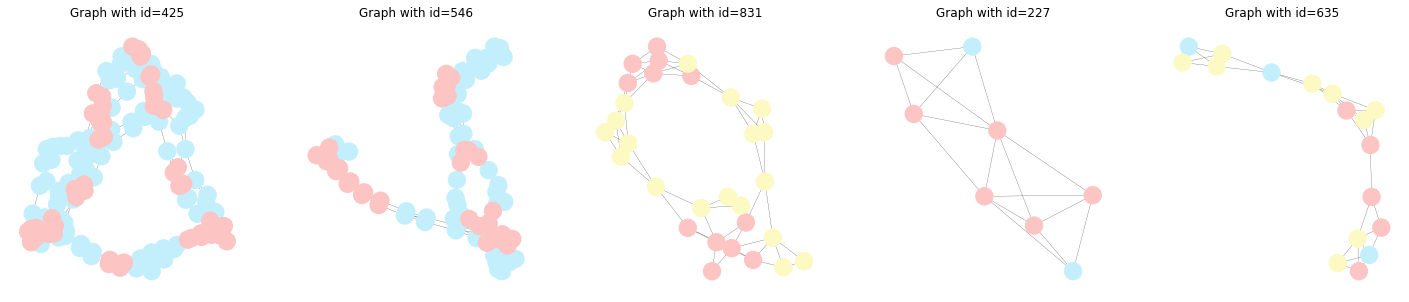

In [ ]:
n_examples = 5

fix, ax = plt.subplots(nrows=1, ncols=n_examples, figsize=(5*n_examples, 5))

for i, rand_ix in enumerate(np.random.choice(dataset.indices(), 5)):
    curr_ax = ax[i]
    curr_ax.set_title(f'Graph with id={rand_ix}')
    
    pg_graph = dataset[rand_ix]
    nx_graph = to_networkx(pg_graph, to_undirected=True)
    colors = [COLORS[np.argmax(features)] for features in pg_graph.x]
    
    draw_colored_graph(nx_graph, colors, labels={}, ax=curr_ax)

## Graph classification with GCN

In case of **graph classification**, when we have $C$ classes, our aim is to predict a **single class for the whole graph**. This means that for each graph $G$ from the dataset, our model $f$ takes as input the set of its nodes $V$ represented by a feature matrix $\boldsymbol{Z}^0=(\boldsymbol{z}^0_1,\dots,\boldsymbol{z}^0_N)^{\text{T}}$, set of its edges $E$ represented by adjacency matrix $\boldsymbol{A}$, and outputs a single value – the class of the input graph (or to be more precise, the vector of $C$ probabilities that the graph belongs to each of $C$ classes):

$$
f(G)=f(\boldsymbol{Z}^0, \boldsymbol{A})=(p_1,\dots,p_C)^{\text{T}}\in[0,1]^{C},\ \text{where}\ \sum_{c=1}^Cp_c=1.\tag{15}
$$

At first, let's create data loaders for training, validation and testing. For that, we will use [PyG DataLoader](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader) that combines input graphs into batches. One batch is represented as a single graph with multiple disconnected components.

In [ ]:
from torch_geometric.loader import DataLoader

In [ ]:
batch_size = 4
loader = DataLoader(dataset, batch_size=batch_size)

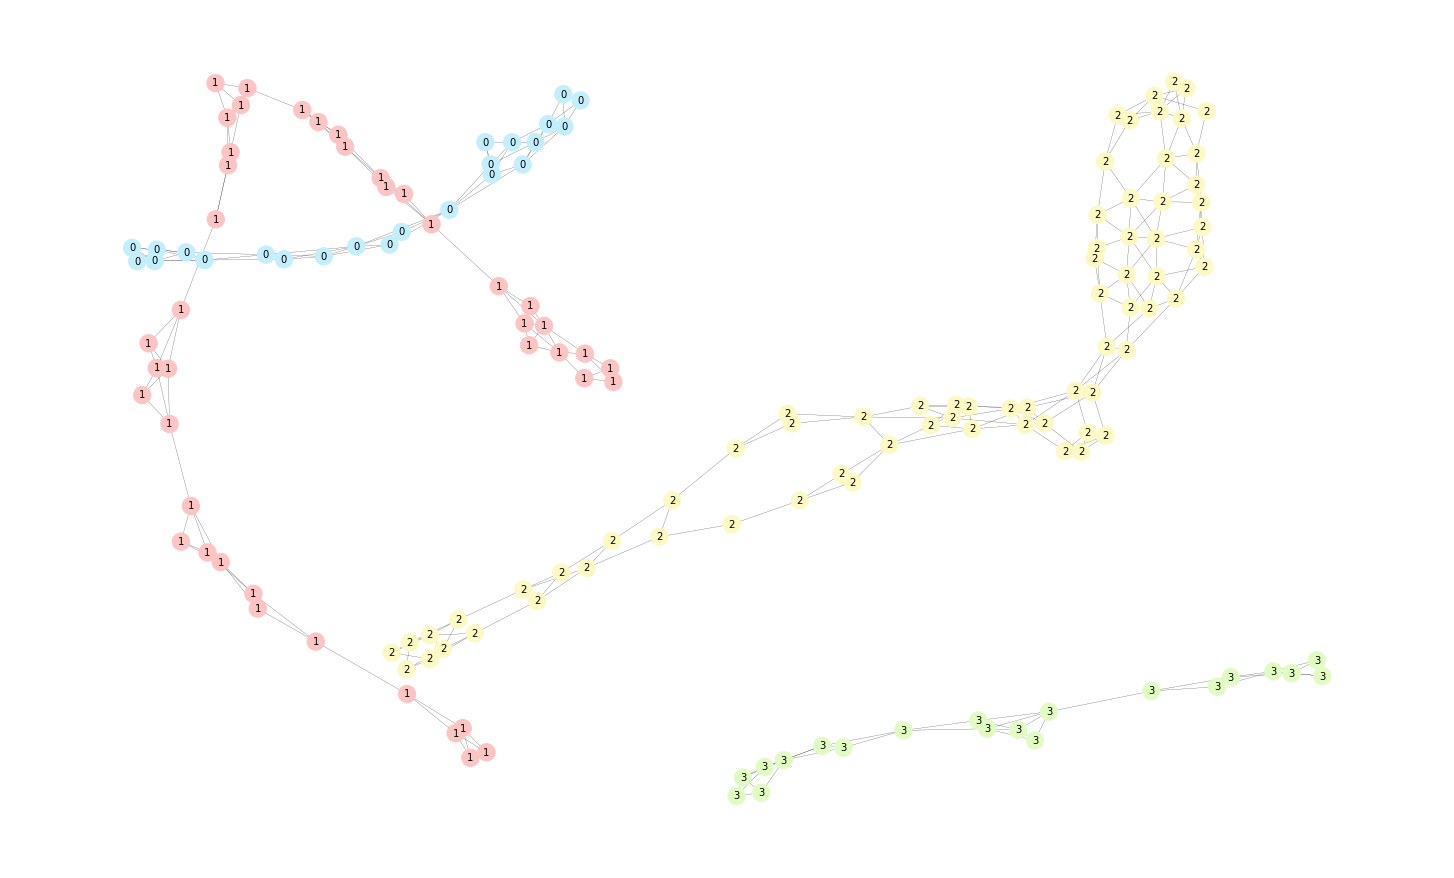

In [ ]:
# Let's pick the first batch and visualize it.
# We will see that it is a simple graph with multiple disconnected components.
# Each component corresponds to a graph in the initial dataset.
# Here for illustration we label and color nodes according to these components

batch = loader.__iter__().next()
nx_graph = to_networkx(batch, to_undirected=True)

mask = np.concatenate([
    np.ones(batch.ptr[i+1] - batch.ptr[i], dtype=int) * i
    for i in range(batch_size) 
])
colors = [COLORS[graph_idx] for graph_idx in mask]
labels = dict(zip(range(len(mask)), mask))


draw_colored_graph(nx_graph, colors=colors, labels=labels)

In [ ]:
batch_size = 32
data_size = len(dataset)

train_loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=batch_size)
val_loader = DataLoader(dataset[int(data_size * 0.8):int(data_size * 0.9)], batch_size=batch_size)
test_loader = DataLoader(dataset[int(data_size * 0.9):], batch_size=batch_size)

### Task 2.1 – Implement GCN Layer

Pytorch Geometric provides the [Message Passing interface](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html) that contains three main functions:
* `message()`, which defines how the message $\color{green}{\boldsymbol{m}_{ij}^{k}}$ is built,
* `aggregate()`, which defines how the messages are aggregated into $\color{red}{\boldsymbol{h}_{i}^{k}},$ 
* `propagate()`, which calls the `message()`, `aggregate()` functions.  

We will implement GCN layer according to the formula (10) on top this interface.

In [ ]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

In [ ]:
from torch import nn

class GCN(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__(aggr='add')
         
        # Create a learnable linear parameter Theta used in formula (10)
        # YOUR CODE HERE
        self.lin = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Linearly transform node feature matrix.
        # YOUR CODE HERE:
        x = self.lin(x)

        # Compute normalization.
        # Hint: function `degree` from torch_geometric.utils can be useful
        # YOUR CODE HERE:
        norm = 1 / torch.sqrt(
            degree(edge_index[0])[edge_index[0]] * 
            degree(edge_index[1])[edge_index[1]]
        )

        # Start propagating messages.
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Normalize node features.
        return norm.view(-1, 1) * x_j

In [ ]:
# Check:
out_channels = 10
gcn_layer = GCN(in_channels=dataset.num_node_features, out_channels=out_channels)

rand_idx = np.random.randint(0, len(dataset))
graph = dataset[rand_idx]
output = gcn_layer(graph.x, graph.edge_index)

if output.shape == torch.Size([graph.num_nodes, out_channels]): 
    print('Good job!')
else:
    print('Error: layer should output a 2-dimensional tensor of shape (N, out_channels)')

Good job!


### Task 2.2 – Implement GNN with GCN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn


class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.0):
        super(GNN, self).__init__()

        # Create a sequence of GCN layers with non-linearities (ReLU)
        # Hint: consider pyg_nn.Sequential, an extension of the torch.nn.Sequential
        # YOUR CODE HERE:
        self.convs = pyg_nn.Sequential(
            'x, edge_index', [
                (GCN(input_dim, hidden_dim), 'x, edge_index -> x'),
                nn.ReLU(),
                (GCN(hidden_dim, hidden_dim), 'x, edge_index -> x'),
                nn.ReLU(),
                (GCN(hidden_dim, hidden_dim), 'x, edge_index -> x'),
                nn.ReLU(),
            ]
        )

        # Create post-message-passing linear transformations and aggregations
        # Hint: try a couple of linear layers with non-linearities (ReLU) and dropout
        # YOUR CODE HERE:
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Apply the sequence of GCN layers with non-linearities (ReLU)
        # YOUR CODE HERE:
        x = self.convs(x, edge_index)
        
        # Aggregate node embeddings tensor of shape (N, hidden_dim) 
        # to get the graph embedding tensor of shape (hidden_dim).
        # Hint 1: pyg_nn.global_max_pool can be useful for graph classification
        # Hint 2: keep in mind that the data is batched
        # YOUR CODE HERE:
        x = pyg_nn.global_max_pool(x, batch) # (B, d_out)
        
        # Apply post-message-passing transformations
        # YOUR CODE HERE:
        x = self.post_mp(x)

        return x

In [ ]:
# Check:
hidden_dim = 10
gnn = GNN(
    input_dim=dataset.num_node_features, 
    hidden_dim=hidden_dim, 
    output_dim=dataset.num_classes, 
)

batch = loader.__iter__().next()
output = gnn(batch)

if output.shape == torch.Size([loader.batch_size, dataset.num_classes]): 
    print('Good job!')
else:
    print('Error: GNN should output a 2-dimensional tensor of shape (batch_size, num_classes)')

Good job!


### Task 2.3 – Train GNN with GCN to predict classes of protein graphs

In [ ]:
def cross_entropy_loss(x, labels):
    return F.cross_entropy(x, labels)


def train(model, optimizer, train_loader, val_loader, epochs):
    train_loss = []
    val_accuracy = []

    for epoch in tqdm(range(epochs)):
        batch_train_loss = []
        batch_val_accuracy = []

        model.train()
        for batch in train_loader:
            # Get logits from the model
            # YOUR CODE HERE:
            logits = model(batch)
            
            # Get ground-truth labels
            # YOUR CODE HERE:
            labels = batch.y

            # Calculate loss
            # YOUR CODE HERE:
            loss = cross_entropy_loss(logits, labels)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            batch_train_loss.append(float(loss.data.numpy()))

        train_loss.append(np.mean(batch_train_loss))

        model.eval()
        for batch in val_loader:
            # Get predictions from the model
            # YOUR CODE HERE:
            pred = torch.argmax(model(batch), dim=1)

            # Get ground-truth labels
            # YOUR CODE HERE:
            labels = batch.y
            
            batch_val_accuracy.append(np.mean((labels == pred).numpy()))

        val_accuracy.append(np.mean(batch_val_accuracy))
        
    return model, train_loss, val_accuracy


def plot_progress(train_loss, val_accuracy):
    fig, (train_ax, val_ax) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    train_ax.plot(train_loss)
    train_ax.set_title('Train loss')
    train_ax.set_xlabel('Epoch')

    val_ax.plot(val_accuracy)
    val_ax.set_title('Val accuracy')
    val_ax.set_xlabel('Epoch')

    plt.show()
    
def evaluate(model, loader):
    model.eval()

    predictions = np.array([])
    labels = np.array([])

    for batch in loader:

        # Get predicted labels
        # YOUR CODE HERE:
        pred = torch.argmax(model(batch), dim=1)

        # Get ground-truth labels
        # YOUR CODE HERE:
        true = batch.y

        predictions = np.append(predictions, pred)
        labels = np.append(labels, true)

    return np.mean(predictions == labels)

In [ ]:
import torch.optim as optim

# Create GNN
# YOUR CODE HERE:
hidden_dim = 16
model = GNN(dataset.num_node_features, hidden_dim, dataset.num_classes, 0.2)

optimizer = optim.Adam(model.parameters(), lr=0.001)

Training:

100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


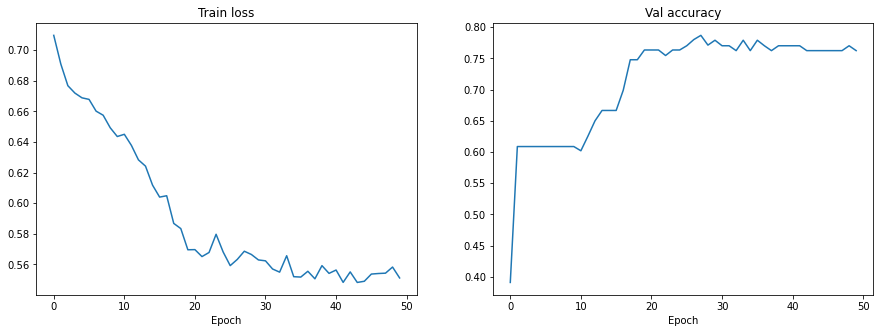

In [ ]:
epochs = 50
model, train_loss, val_accuracy = train(model, optimizer, train_loader, val_loader, epochs)
plot_progress(train_loss, val_accuracy)

Evaluation:

In [ ]:
accuracy = evaluate(model, test_loader)

print('Accuracy:', accuracy)
if accuracy >= 0.65:
    print('Good job!')
else:
    print('Try better!')

Accuracy: 0.7767857142857143
Good job!


## Graph classification with GAT

Let's now implement Graph Attention Layer and perform the same graph classification procedure on PROTEINS dataset with a new GNN that contains GAT layers.

### Task 2.4 – Implement GAT Layer

We will implement multi-head GAT layer according to the formula (14) on top PyG Message-Passing interface.

In [ ]:
import torch_geometric.utils as pyg_utils

class GAT(MessagePassing):
    def __init__(self, in_channels, out_channels, num_heads):
        super(GAT, self).__init__(aggr='add')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_heads = num_heads
        
        # Create a learnable linear parameter Theta used in formula (14)
        # Hint: keep in mind that we have multiple independent heads
        # YOUR CODE HERE:
        self.lin = nn.Linear(self.in_channels, self.num_heads * self.out_channels, bias=False)
        
        # Create a learnable attention vector that is used in formula (13)
        self.att = nn.Parameter(torch.Tensor(1, self.num_heads, 2 * out_channels))
        
        # Initialization of the attention vector
        nn.init.xavier_uniform_(self.att)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        # Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        # Apply linear transformation to the node feature matrix.
        # (N, input_dim) -> (N, n_heads * out_dim)
        # YOUR CODE HERE:
        x = self.lin(x)

        # Start propagating messages.
        return self.propagate(edge_index=edge_index, x=x)

    def message(self, x_i, x_j, index):
        # Constructs messages to node i for each edge (j, i).
        # x_i – feature vectors of target nodes corresponding to i-th index, i.e. x[edge_index[1]]
        # x_j – feature vectors of source nodes corresponding to j-th index, i.e. x[edge_index[0]]
        # index – target (i-th) nodes indices, i.e. edge_index[1]

        # Compute the attention coefficients alpha as described in equation (13).
        # Remember to be careful of the number of heads with dimension!

        # x_i (E, L * d_out) -> (E, L, d_out)
        x_i = x_i.view(-1, self.num_heads, self.out_channels)
        x_j = x_j.view(-1, self.num_heads, self.out_channels)

        # Concatenate features
        # YOUR CODE HERE:
        concatenated_features = torch.cat([x_i, x_j], dim=-1)

        # Multiply concatenated features by the attention vector
        alpha = (concatenated_features * self.att).sum(dim=-1).unsqueeze(-1)
        
        # Apply LeakyReLU and Softmax
        # Hint: function pyg_utils.softmax can be useful here
        # YOUR CODE HERE:
        alpha = F.leaky_relu(alpha)
        alpha = pyg_utils.softmax(alpha, index=index)
        
        return (alpha * x_j).mean(dim=1)

In [ ]:
# Check:
out_channels = 10
num_heads = 3
gat_layer = GAT(in_channels=dataset.num_node_features, out_channels=out_channels, num_heads=num_heads)

rand_idx = np.random.randint(0, len(dataset))
graph = dataset[rand_idx]
output = gat_layer(graph.x, graph.edge_index)

if output.shape == torch.Size([graph.num_nodes, out_channels]): 
    print('Good job!')
else:
    print('Error: layer should output a 2-dimensional tensor of shape (N, out_channels)')

Good job!


### Task 2.5 – Implement GNN with GAT

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn


class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads, dropout=0.0):
        super(GNN, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout

        # Create a sequence of GAT layers
        # YOUR CODE HERE:
        self.convs = self.convs = pyg_nn.Sequential(
            'x, edge_index', [
                (GAT(input_dim, hidden_dim, num_heads), 'x, edge_index -> x'),
                nn.ReLU(),
                (GAT(hidden_dim, hidden_dim, num_heads), 'x, edge_index -> x'),
                nn.ReLU(),
                (GAT(hidden_dim, hidden_dim, num_heads), 'x, edge_index -> x'),
                nn.ReLU(),
            ]
        )

        # Create post-message-passing linear transformations and aggregations
        # Hint: try a couple of linear layers with non-linearities (ReLU) and dropout
        # YOUR CODE HERE:
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Apply GAT layers with non-linearities (ReLU)
        # YOUR CODE HERE:
        x = self.convs(x, edge_index)
        
        # Aggregate node embeddings tensor of shape (N, hidden_dim) 
        # to get the graph embedding tensor of shape (hidden_dim).
        # Hint 1: pyg_nn.global_max_pool can be useful for graph classification
        # Hint 2: keep in mind that the data is batched
        # YOUR CODE HERE:
        x = pyg_nn.global_max_pool(x, batch)
        
        # Apply post-message-passing transformations
        # YOUR CODE HERE:
        x = self.post_mp(x)

        return x

In [ ]:
# Check:
hidden_dim = 10
num_layers = 3
num_heads = 3

gnn = GNN(
    input_dim=dataset.num_node_features, 
    hidden_dim=hidden_dim, 
    output_dim=dataset.num_classes, 
    num_heads=num_heads, 
)

batch = loader.__iter__().next()
output = gnn(batch)

if output.shape == torch.Size([loader.batch_size, dataset.num_classes]): 
    print('Good job!')
else:
    print('Error: GNN should output a 2-dimensional tensor of shape (batch_size, num_classes)')

Good job!


### Task 2.6 – Train GNN with GAT to predict classes of protein graphs

In [ ]:
import torch.optim as optim

# Create GNN
# YOUR CODE HERE:
model = GNN(input_dim=3, hidden_dim=16, output_dim=2, num_heads=3, dropout=0.2)

optimizer = optim.Adam(model.parameters(), lr=0.001)

Training:

100%|██████████| 50/50 [00:58<00:00,  1.18s/it]


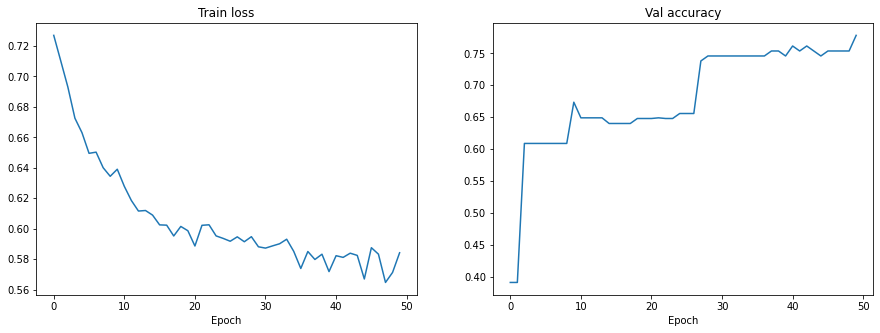

In [ ]:
epochs = 50
model, train_loss, val_accuracy = train(model, optimizer, train_loader, val_loader, epochs)
plot_progress(train_loss, val_accuracy)

Evaluation:

In [ ]:
accuracy = evaluate(model, test_loader)

print('Accuracy:', accuracy)
if accuracy >= 0.65:
    print('Good job!')
else:
    print('Try better!')

Accuracy: 0.75
Good job!


## Node classification: CORA dataset

CORA is a standard citation network benchmark dataset. In this dataset, nodes correspond to documents and edges correspond to undirected citations. Each node has a class label. The node features are elements of a bag-or-words representation of a document. For the Cora dataset, there are 2708 nodes, 5429 edges, 7 prediction classes for nodes, and 1433 features per node. We will be performing node classification on CORA.

This dataset can be obtained from PyTorch Geometric: https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html

In [ ]:
from torch_geometric.datasets import Planetoid

In [ ]:
dataset = Planetoid(root='data/Cora', name='Cora')

Processing...
Done!


In [ ]:
print(f'Number of graphs: {len(dataset)}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of node features: {dataset.num_features}')

Number of graphs: 1
Number of classes: 7
Number of node features: 1433


### Task 2.7 – GNN for node classification

Let's implement a GNN (with GCN or GAT) that will perform node classification.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn


class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=1, dropout=0.0):
        super(GNN, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout

        # Create a sequence of GAT layers
        # YOUR CODE HERE:
        self.convs = nn.ModuleList()
        self.convs.append(GCN(input_dim, hidden_dim))
        for l in range(self.num_layers - 1):
            self.convs.append(GCN(hidden_dim, hidden_dim))

        # Create post-message-passing linear transformations and aggregations
        # Hint: try a couple of linear layers with non-linearities (ReLU) and dropout
        # YOUR CODE HERE:
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(), 
            nn.Dropout(self.dropout), 
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Apply GAT layers with non-linearities (ReLU)
        # YOUR CODE HERE:
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
        
        # Apply post-message-passing transformations
        # YOUR CODE HERE:
        x = self.post_mp(x)

        return x

In [ ]:
# Check:
hidden_dim = 10
num_layers = 3
gnn = GNN(
    input_dim=dataset.num_node_features, 
    hidden_dim=hidden_dim, 
    output_dim=dataset.num_classes,
    num_heads=3,
)

graph = dataset[0]
output = gnn(graph)

if output.shape == torch.Size([graph.num_nodes, dataset.num_classes]): 
    print('Good job!')
else:
    print('Error: GNN should output a 2-dimensional tensor of shape (num_nodes, num_classes)')

Good job!


### Task 2.8 – Perform node classification

In case of **node classification**, when we have $C$ classes, our aim is to predict a single class **for each node** of the graph. This means that for each graph $G$ from the dataset, our model $f$ takes as input the set of its nodes $V$ represented by a feature matrix $\boldsymbol{Z}^0=(\boldsymbol{z}^0_1,\dots,\boldsymbol{z}^0_N)^{\text{T}}$, set of its edges $E$ represented by adjacency matrix $\boldsymbol{A}$, and outputs the $N\times{C}$ matrix $\boldsymbol{P}=\left(\boldsymbol{p}^{(1)},\dots,\boldsymbol{p}^{(N)}\right)^{\text{T}}$, where the $i$-th row corresponds to vector $\boldsymbol{p}^{(i)}=\left(p^{(i)}_1,\dots,p^{(i)}_C\right)^{\text{T}}$ of $C$ probabilities that the $i$-th node belongs to each of $C$ classes:

$$
f(G)=f(\boldsymbol{Z}^0, \boldsymbol{A})=\boldsymbol{P}\in[0,1]^{N\times{C}},\ \text{where}\ \forall{i}=1,\dots,N\ \sum_{c=1}^Cp^{(i)}_c=1.\tag{16}
$$

CORA dataset contains a single graph where classes of some nodes are known and classes of other nodes should be predicted. In reality, classes of all nodes are known, however this graph contains three specific attributes: `train_mask`, `val_mask`, and `test_mask`:

In [ ]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
len(dataset)

1

These masks can be used in order to keep only specific nodes during training, validation and testing.
Let's implement the training, validation and evaluation procedures that will take into account only results that correspond to the `train/val/test` nodes:

In [ ]:
def train_for_node_classification(model, optimizer, graph, epochs):
    train_loss = []
    val_accuracy = []

    for epoch in tqdm(range(epochs)):
    
        # Training
        model.train()

        # Get results for all nodes of the graph
        logits = model(graph)
        
        # Keep only results corresponding to the training nodes
        # YOUR CODE HERE:
        train_logits = logits[graph.train_mask]
        train_labels = graph.y[graph.train_mask]

        loss = cross_entropy_loss(train_logits, train_labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(loss.detach().numpy())

        # Validation
        model.eval()
        
        # Get predicted labels for all nodes of the graph
        pred = model(graph).max(dim=1)[1]
        
        # Keep only predictions corresponding to the validation nodes
        # YOUR CODE HERE:
        val_pred = pred[graph.val_mask]
        val_labels = graph.y[graph.val_mask]
        
        val_accuracy.append(np.mean((val_labels == val_pred).numpy()))
        
    return model, train_loss, val_accuracy


def evaluate_node_classification(model, graph):
    model.eval()
    mask = graph.test_mask

    # Get predictions and ground-truth labels for test nodes
    # YOUR CODE HERE:
    predictions = model(graph).max(dim=1)[1].numpy()[graph.test_mask]
    labels = graph.y.numpy()[graph.test_mask]

    return np.mean(predictions == labels)

In [ ]:
num_layers = 3
dropout = 0.2
hidden_dim = 16
lr = 0.001

model = GNN(dataset.num_node_features, hidden_dim, dataset.num_classes, num_layers, dropout)
optimizer = optim.Adam(model.parameters(), lr=lr)

Training:

100%|██████████| 200/200 [00:09<00:00, 20.14it/s]


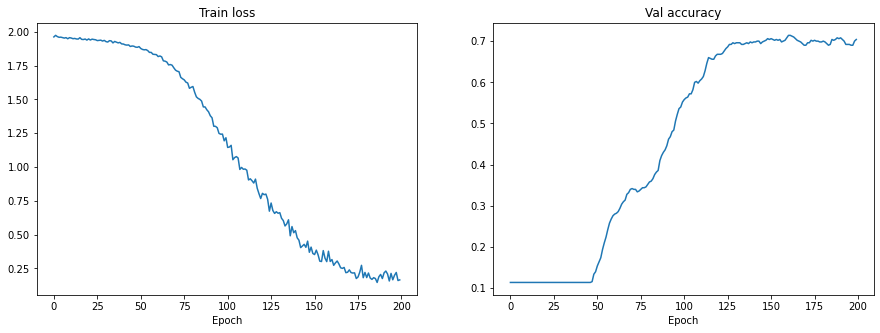

In [ ]:
epochs = 200
model, train_loss, val_accuracy = train_for_node_classification(model, optimizer, dataset[0], epochs)
plot_progress(train_loss, val_accuracy)

In [ ]:
accuracy = evaluate_node_classification(model, dataset[0])

print('Accuracy:', accuracy)
if accuracy >= 0.65:
    print('Good job!')
else:
    print('Try better!')

Accuracy: 0.719
Good job!


# Homework

QM9 is a [molecular dataset](https://www.nature.com/articles/sdata201422) standardized in machine learning as a chemical property prediction benchmark. It consists of small molecules (up to 29 atoms per molecule). Atoms contain positional coordinates embedded in a 3D space, a one-hot encoding vector that defines the type of molecule (H, C, N, O, F) and an integer value with the atom charge. For each molecule, authors of the dataset provide computed geometries minimal in energy, corresponding harmonic frequencies, dipole moments, polarizabilities, along with energies, enthalpies, and free energies of atomization. Any of these values can be considered as targets in the graph regression problem. In this task, we will predict one of them, the energy of the highest occupied molecular orbital $\epsilon_{\text{HOMO}}$.

There are examples of some molecules from QM9 constructed using [PyMOL](https://pymol.org/2/):

<img src="https://i.ibb.co/qDv7Xy0/qm9-examples-v2.jpg" alt="qm9-examples-v2" border="0">

We will download this dataset from [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.QM9):

In [ ]:
from torch_geometric.datasets import QM9

In [ ]:
dataset = QM9(root='data/QM9')
print(f'Dataset contains {len(dataset)} molecules')

## Data

In this dataset, each graph represents a molecule and contains the following attributes:
* `x` – node feature matrix. Feature vector for each node (atom) consists of the following values:
    - `x[:5]` – one-hot encoded atom type: `H`, `C`, `N`, `O`, `F`
    - `x[5]` – atomic number
    - `x[6]` - if the atom is aromatic or not (boolean value)
    - `x[7:10]` – one-hot encoded hybridization type of orbitals of the atom: `SP`, `SP2`, `SP3`
    - `x[10]` – number of hydrogens connected to the atom
* `edge_index` – edges (covalent bonds) between atoms
* `edge_attr` – matrix of edge attributes, where a vector of attributes for each edge is one-hot incoded bond type: `single`, `double`, `triple`, `aromatic`
* `y` – list of 19 scalar  properties of the molecule, see details in the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.QM9)
* `pos` – 3D coordinates of atoms
* `idx` – index of the molecule
* `z` – vector of atomic numbers of atoms

In [ ]:
dataset[0]

We split in the same way as described in [this paper](https://arxiv.org/abs/1906.04015):

In [ ]:
import gdown

!gdown https://drive.google.com/uc?id=1gShdT4AhKeBSCY1AAYTc4_uPVWbYvWou
!gdown https://drive.google.com/uc?id=1qrBR8IcbUo0tjRh0Koca4fVqcwyFXqiY
!gdown https://drive.google.com/uc?id=1nwlPwbK5ze5R76cYRQ3iuXtFnHtquJlO
!gdown https://drive.google.com/uc?id=1BAxPRre69htPj1aXLHdf62TLxE055atd

In [ ]:
import numpy as np

train_ids = set(np.loadtxt('qm9_train_ids.txt', dtype=int))
val_ids = set(np.loadtxt('qm9_val_ids.txt', dtype=int))
test_ids = set(np.loadtxt('qm9_test_ids.txt', dtype=int))
bad_ids = set(np.loadtxt('qm9_bad_ids.txt', dtype=int))

In [ ]:
from tqdm import tqdm

train_data = []
val_data = []
test_data = []

for graph in tqdm(dataset):
    graph_id = int(graph.idx) + 1
    if graph_id in bad_ids:
        continue
    if graph_id in train_ids:
        train_data.append(graph)
    elif graph_id in val_ids:
        val_data.append(graph)
    elif graph_id in test_ids:
        test_data.append(graph)

In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [ ]:
print(len(train_data), len(train_loader))
print(len(val_data), len(val_loader))
print(len(test_data), len(test_loader))

## Task

The task is to predict the energy of the highest occupied molecular orbital $\epsilon_{\text{HOMO}}$ which is `y[2]` in the graph data (see details in the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.QM9)).

The main rule is to write by youreslf all the graph learning models that you use. **Importing models from PyG is not allowed**. However, you can import and use all the auxiliary functions from `torch_geometric.utils` as well as auxiliary classes such as `torch_geometric.nn.MessagePassing`.



## Ideas

You can try different types of graphs:
- nodes are atoms and edges are covalent bonds (default version)
- nodes are atoms and adges are built based on the distance cutoff (e.g. 5Å)
- nodes are covalent bonds and edges are angles between these bonds
- etc.

Different graph learning models:

- as a baseline, you can try classical [GCNs](https://arxiv.org/abs/1609.02907), [GATs](https://arxiv.org/abs/1710.10903), etc.
- GNNs that include edge data transformation: [EdgeConv](https://arxiv.org/abs/1801.07829), [RGCNConv](https://arxiv.org/abs/1703.06103)
- take into account geometry: [SchNet](https://arxiv.org/abs/1706.08566), [DimeNet](https://arxiv.org/abs/2003.03123), [EGNNs](https://arxiv.org/abs/2102.09844), etc.

## Expected results

In this task, we expect that you will implement and train two architectures. You can choose any architectures except ones that were explained in seminar. To give an idea about expected performance values, there are some results reported in the literature.

|Method|$\epsilon_{\text{HOMO}}$ MAE, [meV]|
|---|---|
|[MPNN](https://arxiv.org/abs/1704.01212)|990|
|[SchNet](https://arxiv.org/abs/1706.08566)|41|
|[EGNN](https://arxiv.org/abs/2102.09844)|29|
|[DimeNet](https://arxiv.org/abs/2003.03123)|28|
